In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

In [39]:
%matplotlib inline
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

import sys
sys.path.insert(0, '/Users/bmmorris/git/gravdark/')

sys.path.insert(0, '/Users/bmmorris/git/friedrich/')


from gravdark import LightCurve
from gravdark.lightcurve import concatenate_light_curves
from friedrich.lightcurve import hat11_params_morris

params = hat11_params_morris()

h11_path = glob('/Users/bmmorris/data/hat11/*slc.fits')
h11_lc_whole = LightCurve.from_raw_fits(h11_path, name='HAT-P-1 b')

h11_masked = LightCurve(**h11_lc_whole.mask_out_of_transit(params, oot_duration_fraction=0.5))
h11_transits = h11_masked.get_transit_light_curves(params)
for transit in h11_transits:
    transit.remove_linear_baseline(params)
h11 = concatenate_light_curves(h11_transits)

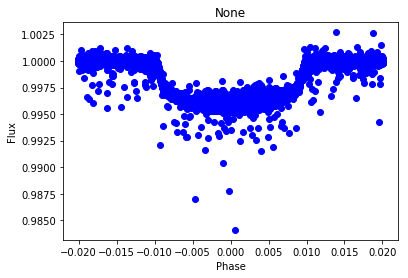

In [40]:
h11.plot(params, phase=True)

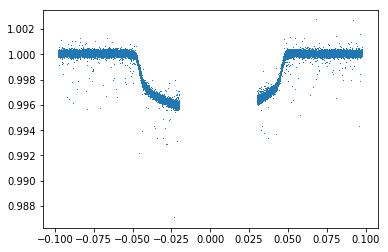

In [77]:
times = (h11.times.jd - params.t0) % params.per
times[times > params.per/2] -= params.per

all_fluxes = h11.fluxes[np.argsort(times)]
times = times[np.argsort(times)]
yerr = np.std(all_fluxes[:1000])

mask = (times < -0.02) | (times > 0.03)

plt.plot(times[mask], all_fluxes[mask], ',', rasterized=True)

In [42]:
# fig, ax = plt.subplots(figsize=(4, 3))
# ax.plot(times, all_fluxes, color='k', label='Spotted')
# ax.plot(times, spotless_lc, color='gray', ls='--', label='Spotless')
# ax.legend()
# for s in ['right', 'top']:
#     ax.spines[s].set_visible(False)
# ax.grid(ls=':')
# ax.set(xlabel='Time from $t_0$ [d]', ylabel='Flux')
# fig.savefig('transit_quad.pdf', bbox_inches='tight')

In [81]:
from copy import deepcopy
import batman

def kipping_to_quadratic(p):
    q1, q2 = p
    u1 = 2*np.sqrt(q1)*q2
    u2 = np.sqrt(q1)*(1 - 2*q2)
    return u1, u2

def transit_model(theta, x):
    r0, r1, q1, q2, f0 = theta
    trial_params = deepcopy(params)
    trial_params.rp0 = r0
    trial_params.rp1 = r1
    trial_params.u = kipping_to_quadratic([q1, q2])
    trial_params.t0 = 0
    
    m = batman.TransitModel(trial_params, x, exp_time=1/60/24, supersample_factor=2)
    fluxes = f0 * m.light_curve(trial_params)
    
    return fluxes
    
def lnlike(theta, x, y, yerr):
    r0, r1, q1, q2, f0 = theta
    model = transit_model(theta, x) 
    return -0.5*np.sum((model - y)**2 / yerr**2)

def lnprior(theta):
    r0, r1, q1, q2, f0 = theta
    if 0 < r0 < 1 and 0.0 < r1 < 1 and 0 < q1 < 1 and 0 < q2 < 1 and 0 < f0 < 1.5:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


ndim, nwalkers = 5, 10
#pos = [[params.rp, params.rp, 0] + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
pos = []

q1 = (params.u[0] + params.u[1])**2
q2 = 0.5 * params.u[0] / (params.u[0] + params.u[1])

while len(pos) < nwalkers: 
    trial_pos = [params.rp, params.rp, q1, q2, 1] + 1e-2*np.random.randn(ndim)
    if np.isfinite(lnprior(trial_pos)):
        pos.append(trial_pos)

import emcee
fluxes = all_fluxes
# yerr = np.ones_like(fluxes) * fluxes.std()/10
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(times[mask], fluxes[mask], yerr),
                                threads=8)

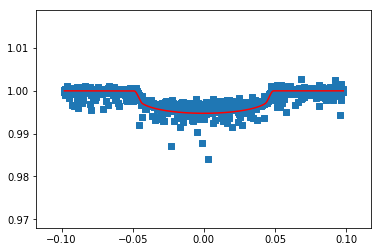

In [82]:
init_f = transit_model([params.rp*0.9, params.rp*1.1, q1, q2, 1], times)

#plt.errorbar(times, fluxes, yerr, fmt='.', color='k', ecolor='gray')
plt.scatter(times, all_fluxes, marker=',')
plt.plot(times, init_f, 'r', zorder=10)

In [83]:
sampler.run_mcmc(pos, 10000); 

In [84]:
np.savetxt('hat11_samples.txt', sampler.flatchain)

In [85]:
params.rp

0.058330305324663184

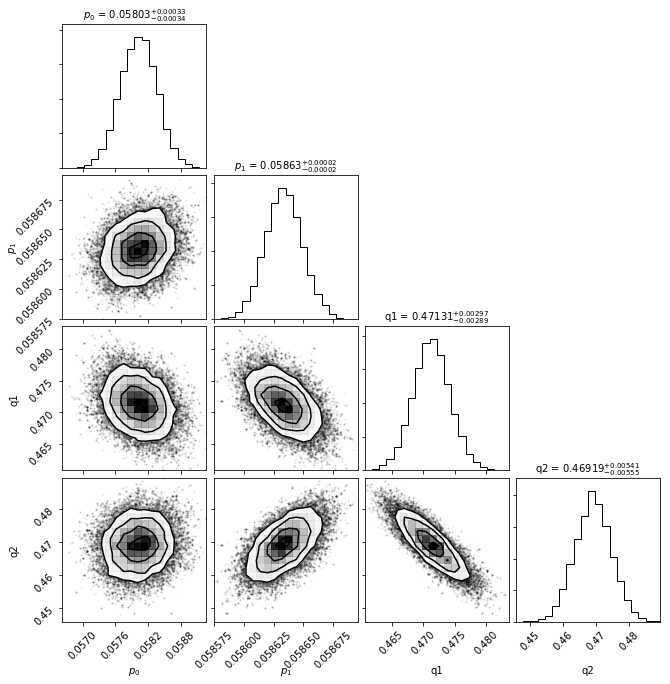

In [86]:
from corner import corner

nburnin = 5000
# fig, ax = plt.subplots(2, 2, figsize=(4, 4))
corner(sampler.chain[:, 5000:, :-1].reshape((-1, ndim-1)), #truths=[params.rp, params.rp], fig=fig, 
       labels=['$p_0$', '$p_1$', 'q1', 'q2'], show_titles=True, title_fmt='.5f', title_kwargs=dict(fontsize=10));

# for i, axis in enumerate(fig.axes):
#     axis.set_xlim([0.0771, 0.0782])
#     if i == 3: 
#         axis.set_xlim([0.07748, 0.07756])
# plt.savefig('corner_quad_hat11.pdf', bbox_inches='tight')

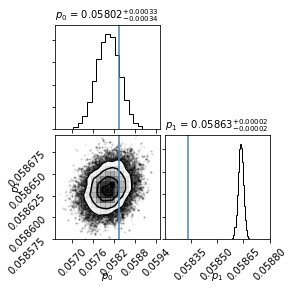

In [94]:
fig, ax = plt.subplots(2, 2, figsize=(4, 4))
corner(sampler.chain[:, 3000:, :2].reshape((-1, ndim-3)), truths=[params.rp, params.rp], 
       labels=['$p_0$', '$p_1$'], fig=fig, show_titles=True, title_fmt='.5f', title_kwargs=dict(fontsize=10));

for i, axis in enumerate(fig.axes):
    axis.set_xlim([0.0565, 0.0595])
    if i == 3: 
        axis.set_xlim([0.0582, 0.0588])
plt.savefig('corner_quad_hat11.pdf', bbox_inches='tight')

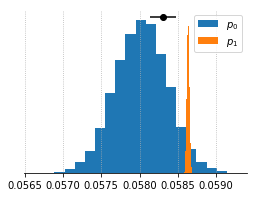

In [110]:
plt.figure(figsize=(4, 3))

fmax = 0
for p, label in zip(sampler.chain[:, 5000:, :2].reshape((-1, ndim-3)).T, 
                    ['$p_0$', '$p_1$']):
    n, _, _ = plt.hist(p, bins=20, histtype='stepfilled', label=label)
    fmax = max([n.max(), fmax])
ax = plt.gca()
ax.grid(ls=':')
ax.legend()
ax.set(yticks=[])

depth, depth_err = 0.00340, 0.00002
rprs_lit, rprs_err_lit = depth**0.5, 0.5*depth_err/np.sqrt(depth)

ax.errorbar(rprs_lit, fmax, xerr=rprs_err_lit, fmt='o', color='k')

for s in ['right', 'top', 'left']:
    ax.spines[s].set_visible(False)
plt.savefig('hat11_agreement.pdf', bbox_inches='tight')

In [37]:
# plt.scatter(sampler.chain[:, 3000:, 0], sampler.chain[:, 3000:, 1], marker=',', 
#             s=1, alpha=0.5, rasterized=True)
# plt.axvline(params.rp, color='k')
# plt.axhline(params.rp, color='k')

# ax = plt.gca()

# for s in ['right', 'top']:
#     ax.spines[s].set_visible(False)
# # ax.set(xlim=[params.rp-0.1, params.rp+0.1], ylim=[params.rp-0.1, params.rp+0.1])
# ax.set_aspect(1)
# ax.grid(ls=':')
# ax.set(xlabel='$p_0$ (duration)', ylabel='$p_1$ (depth)')
# plt.savefig('depth_posterior_hat7.pdf', dpi=250, bbox_inches='tight')

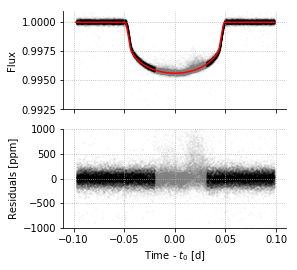

In [96]:
fig, ax = plt.subplots(2, 1, figsize=(4, 4), sharex=True)
ax[0].scatter(times[mask], fluxes[mask], marker=',', s=1, rasterized=True, alpha=0.01, 
              color='k')
ax[0].scatter(times[~mask], fluxes[~mask], marker=',', s=1, rasterized=True, alpha=0.01, 
              color='gray')

i = np.argmax(sampler.flatlnprobability, axis=0)
ax[0].plot(times, transit_model(sampler.flatchain[i, :], times), color='r')

ax[1].scatter(times[mask], 1e6*(fluxes[mask] - transit_model(sampler.flatchain[i, :], times[mask])), 
              marker=',', s=1, rasterized=True, alpha=0.02, 
              color='k')

ax[1].scatter(times[~mask], 1e6*(fluxes[~mask] - transit_model(sampler.flatchain[i, :], times[~mask])), 
              marker=',', s=1, rasterized=True, alpha=0.02, 
              color='gray')

ax[0].set_ylim([0.9925, 1.001])
ax[1].set_ylim([-1000, 1000])

ax[0].set_ylabel('Flux')
ax[1].set(xlabel='Time - $t_0$ [d]', ylabel='Residuals [ppm]')

for axis in ax:
    for s in ['right', 'top']:
        axis.spines[s].set_visible(False)
    axis.grid(ls=':')

fig.savefig('hat11_residuals.pdf', bbox_inches='tight', dpi=250)

(array([  1.60000000e+01,   3.40000000e+02,   2.01800000e+03,
          8.23400000e+03,   1.71890000e+04,   2.10700000e+04,
          1.44270000e+04,   5.45000000e+03,   1.12100000e+03,
          1.35000000e+02]),
 array([ 0.96583029,  0.97028239,  0.97473449,  0.97918659,  0.98363869,
         0.98809079,  0.99254289,  0.99699499,  1.00144709,  1.00589919,
         1.01035129]),
 <a list of 10 Patch objects>)

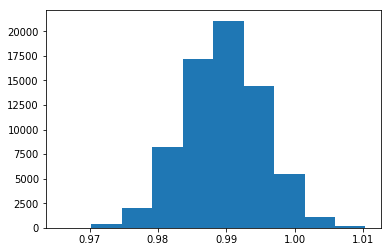

In [97]:
p0 = sampler.chain[:, 3000:, 0].ravel()
p1 = sampler.chain[:, 3000:, 1].ravel()

plt.hist(p0/p1)